Code adapted from: https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# install kaggle api to download the dataset

In [1]:
%pip install -q kaggle

Note: you may need to restart the kernel to use updated packages.


# Start downloading the datasets
### The dataset used is: https://www.kaggle.com/datasets/benpepperpots/rust-iron-dataset?select=train

In [3]:
!mkdir -p rust_dataset
!kaggle datasets download -d benpepperpots/rust-iron-dataset -p rust_dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/benpepperpots/rust-iron-dataset
License(s): unknown
100%|████████████████████████████████████████| 729M/729M [08:01<00:00, 1.59MB/s]



### the datasets path is rust_dataset/train/train/ rust_dataset/test/test/, organized them as rust_dataset/train/

In [4]:
!mv rust_dataset/train/train/* rust_dataset/train/
!mv rust_dataset/test/test/* rust_dataset/test/
!rmdir rust_dataset/train/train
!rmdir rust_dataset/test/test

In [38]:
import os
import time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.ion()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps") # mac
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


### Load data

In [21]:
from pathlib import Path

train_dir = Path("rust_dataset/train")
val_dir   = Path("rust_dataset/test")

In [22]:
# Data augmentation and normalization for training
# Just normalization for validation
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

In [23]:
# create datasets
train_ds = ImageFolder(train_dir, transform=train_tfms)
val_ds   = ImageFolder(val_dir, transform=val_tfms)

print("Classes:", train_ds.classes)
print("Train size:", len(train_ds))
print("Val size:", len(val_ds))

Classes: ['CORROSION', 'NOCORROSION']
Train size: 1273
Val size: 182


In [24]:
# data loaders
batch_size = 32

num_workers = 0 if device.type == "mps" else 2
pin_memory = True if device.type == "cuda" else False

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train batches: 40
Val batches: 6


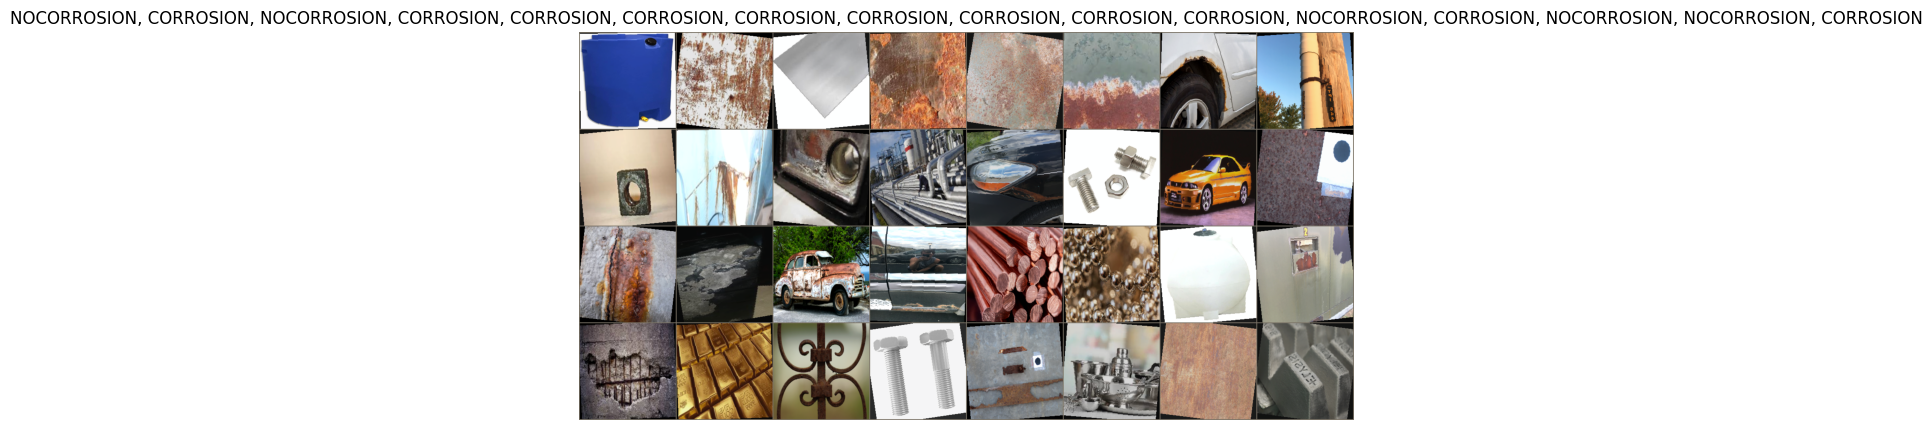

In [25]:
# visualize a few
def imshow(inp, title=None):
    """Display image for Tensor (expects CHW or grid tensor)."""
    inp = inp.detach().cpu().numpy().transpose((1, 2, 0))  # CHW -> HWC

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(10, 6))
    plt.imshow(inp)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training data
inputs, labels = next(iter(train_loader))

# Make a grid from batch
grid = torchvision.utils.make_grid(inputs, nrow=8)

# Create titles from labels
class_names = train_ds.classes
title = ", ".join([class_names[i] for i in labels[:16]])  # show first 16 labels in title

imshow(grid, title=title)

# Train model

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, best_path="best_model.pt"):
    since = time.time()

    dataloaders = {"train": train_loader, "val": val_loader}
    dataset_sizes = {"train": len(train_ds), "val": len(val_ds)}

    best_acc = 0.0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()

            if phase == "train" and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_path)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(torch.load(best_path, map_location=device))
    return model, history

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()

    images_so_far = 0
    plt.figure(figsize=(8, 8))

    class_names = train_ds.classes  # use dataset classes

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1

                plt.subplot(num_images // 2, 2, images_so_far)
                plt.axis("off")
                plt.title(f"Pred: {class_names[preds[j]]}")

                # show single image (unnormalized)
                imshow(inputs[j].cpu())

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    return

    model.train(mode=was_training)

### load the pretrained weights anf freeze the backbone
### here is the dataset that was used to get the weights: https://www.kaggle.com/datasets/sautkin/imagenet1k1
### weights:https://docs.pytorch.org/vision/main/models.html

In [ ]:
num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes, "| num_classes:", num_classes)

model_conv = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) # load weight

# Freeze backbone
for param in model_conv.parameters():
    param.requires_grad = False

# Replace classifier head
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

# Confirm device (0 for mps, might be somthing else if using other platform)
print("Model device:", next(model_conv.parameters()).device)

criterion = nn.CrossEntropyLoss()

# Only optimize the final layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Classes: ['CORROSION', 'NOCORROSION'] | num_classes: 2
Model device: mps:0


In [35]:
model, history = train_model(
    model=model_conv, 
    criterion=criterion,
    optimizer=optimizer_conv,
    scheduler=exp_lr_scheduler,
    num_epochs=10,
    best_path="resnet18_best.pt"
)

Epoch 1/10
----------
train Loss: 0.5615 Acc: 0.7023
val Loss: 0.2827 Acc: 0.9176

Epoch 2/10
----------
train Loss: 0.3003 Acc: 0.8900
val Loss: 0.2382 Acc: 0.9231

Epoch 3/10
----------
train Loss: 0.2791 Acc: 0.8932
val Loss: 0.2390 Acc: 0.9011

Epoch 4/10
----------
train Loss: 0.2455 Acc: 0.9120
val Loss: 0.2659 Acc: 0.8846

Epoch 5/10
----------
train Loss: 0.2451 Acc: 0.9089
val Loss: 0.2966 Acc: 0.8791

Epoch 6/10
----------
train Loss: 0.2500 Acc: 0.8995
val Loss: 0.2460 Acc: 0.8901

Epoch 7/10
----------
train Loss: 0.2214 Acc: 0.9120
val Loss: 0.1926 Acc: 0.9396

Epoch 8/10
----------
train Loss: 0.1916 Acc: 0.9269
val Loss: 0.1968 Acc: 0.9231

Epoch 9/10
----------
train Loss: 0.1863 Acc: 0.9317
val Loss: 0.2035 Acc: 0.9176

Epoch 10/10
----------
train Loss: 0.1892 Acc: 0.9301
val Loss: 0.2062 Acc: 0.9231

Training complete in 3m 17s
Best val Acc: 0.9396


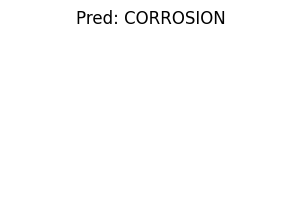

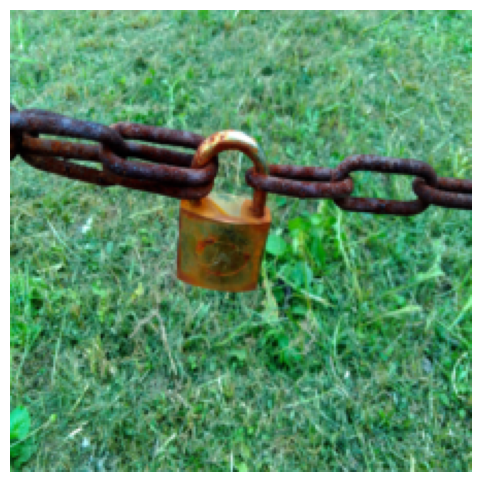

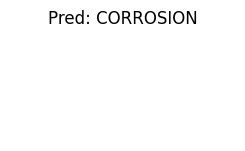

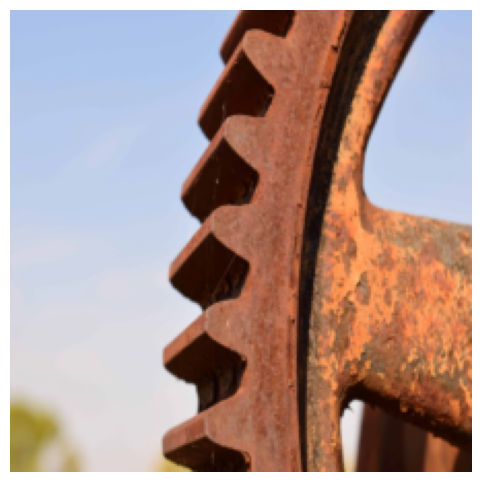

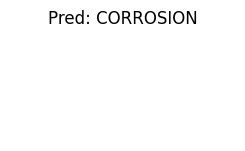

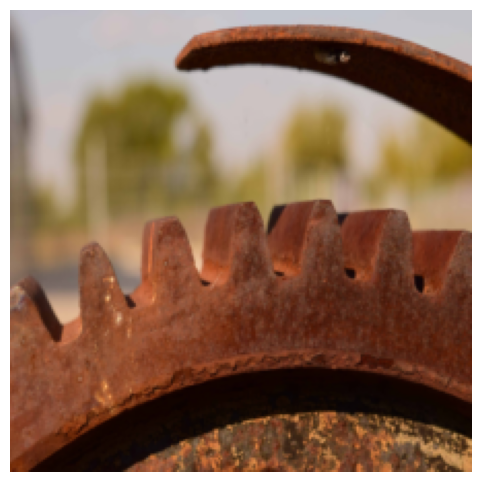

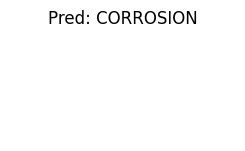

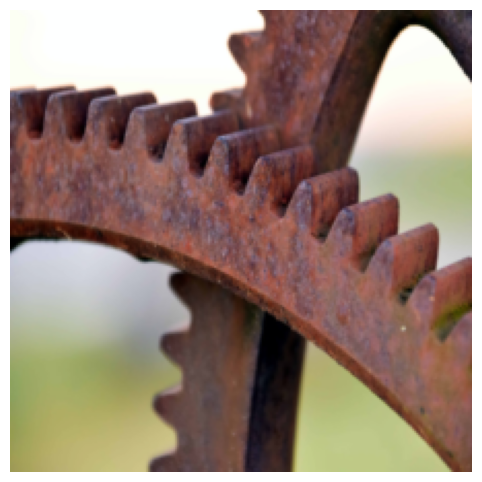

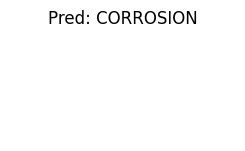

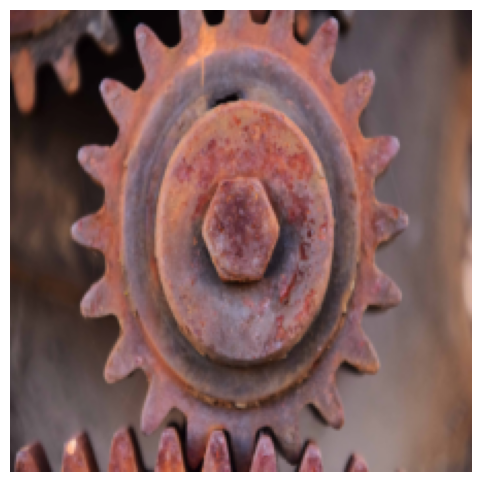

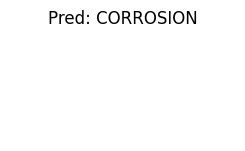

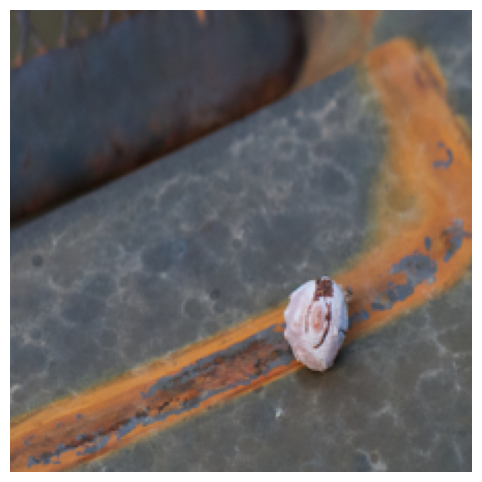

<Figure size 640x480 with 0 Axes>

In [36]:
visualize_model(model_conv)

plt.ioff()
plt.show()

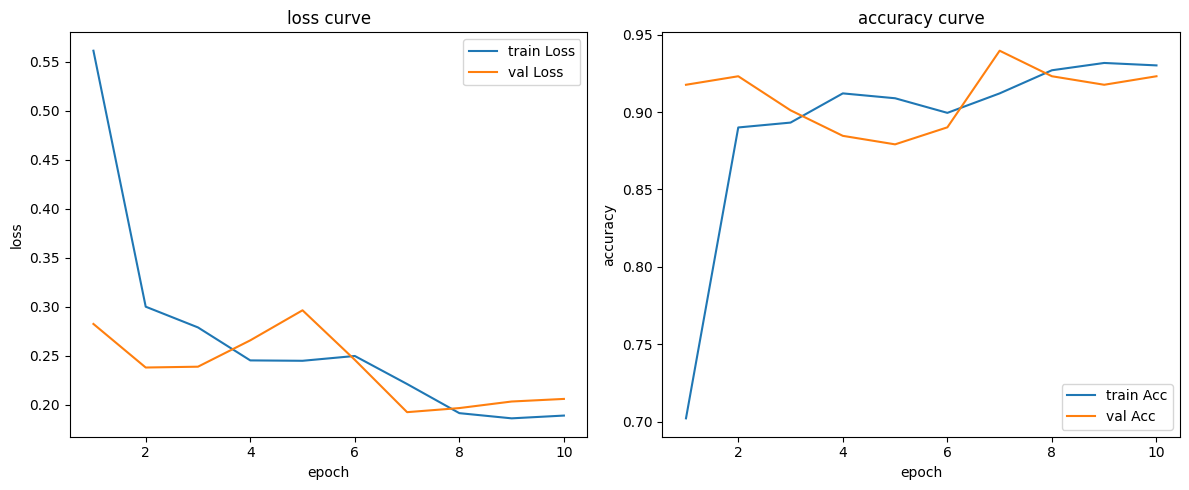

In [37]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="train Loss")
plt.plot(epochs_range, history["val_loss"], label="val Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss curve")
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="train Acc")
plt.plot(epochs_range, history["val_acc"], label="val Acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("accuracy curve")
plt.legend()

plt.tight_layout()
plt.show()

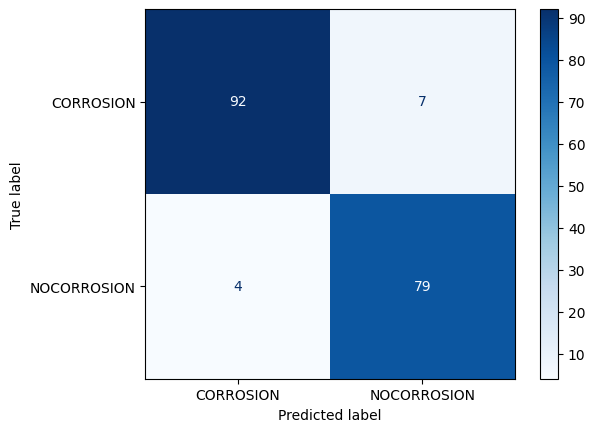

In [40]:
@torch.no_grad()
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    for x, y in loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

    return all_labels, all_preds

labels, preds = get_predictions(model, val_loader)

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=train_ds.classes)
disp.plot(cmap="Blues")
plt.show()

(92+79)/182 ~ 94% accuracy